Dataset of this project can be downloaded in https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022.

# **Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
!pip install mplcyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing Data**

In [ ]:
df = pd.read_csv('NYC.csv')

# **Data Exploration**

In [ ]:
df.head()

,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0
3,2016-01-01T03:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0
4,2016-01-01T04:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0


In [ ]:
df.isnull().sum()

time                       0
temperature_2m (°C)      168
precipitation (mm)       168
rain (mm)                168
cloudcover (%)           168
cloudcover_low (%)       168
cloudcover_mid (%)       168
cloudcover_high (%)      168
windspeed_10m (km/h)     168
winddirection_10m (°)    173
dtype: int64

# **Data Preprocessing**

In [ ]:
#Convert datetime to date in Pandas
df['time']=pd.to_datetime(df['time'])
df['Time'] = df['time'].dt.normalize()

In [ ]:
#Fill missing values pandas with mean
df['temperature_2m (°C)'].fillna(df['temperature_2m (°C)'].mean(), inplace=True)

In [ ]:
df = df[['Time', 'temperature_2m (°C)']]
df.head()

,Time,temperature_2m (°C)
0,2016-01-01,7.6
1,2016-01-01,7.5
2,2016-01-01,7.1
3,2016-01-01,6.6
4,2016-01-01,6.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59760 entries, 0 to 59759
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 59760 non-null  datetime64[ns]
 1   temperature_2m (°C)  59760 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 933.9 KB


# **Plotting Data**

In [ ]:
Time = df['Time'].values
Temp  = df['temperature_2m (°C)'].values

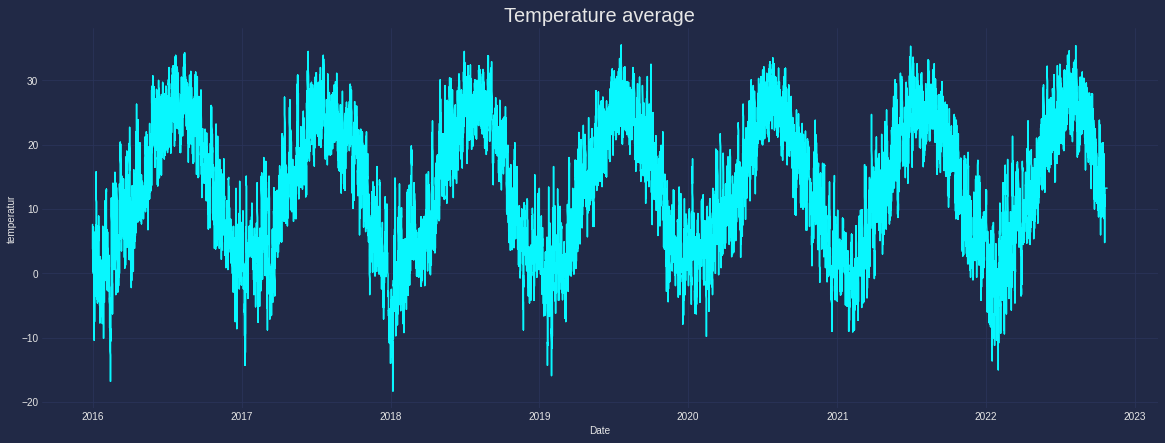

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(Time, Temp)
plt.xlabel('Date')
plt.ylabel('temperatur')
plt.title('Temperature average',
          fontsize=20);

# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Temp, Time, test_size = 0.2, random_state = 0, shuffle=False)

# **Modelling**

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

Treshold mae

In [ ]:
x = (df['temperature_2m (°C)'].max() - df['temperature_2m (°C)'].min()) * 10/100
x

5.38

Callback Function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<x and logs.get('val_mae')<x):
      print("\nMAE < 10% ")
      self.model.stop_training = True
callbacks = myCallback()

Optimizer

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-05, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )

In [ ]:
history = model.fit(
    train_set,
    epochs=200,
    validation_data=test_set,
    verbose=1,
    callbacks=[callbacks]
    )

Epoch 1/200
478/478 [==============================] - 50s 97ms/step - loss: 12.5073 - mae: 12.9983 - val_loss: 15.2371 - val_mae: 15.7322
Epoch 2/200
478/478 [==============================] - 43s 90ms/step - loss: 12.2470 - mae: 12.7372 - val_loss: 14.9204 - val_mae: 15.4151
Epoch 3/200
478/478 [==============================] - 42s 87ms/step - loss: 11.8931 - mae: 12.3823 - val_loss: 14.4728 - val_mae: 14.9669
Epoch 4/200
478/478 [==============================] - 42s 87ms/step - loss: 11.4353 - mae: 11.9238 - val_loss: 13.9090 - val_mae: 14.4027
Epoch 5/200
478/478 [==============================] - 42s 88ms/step - loss: 10.8477 - mae: 11.3355 - val_loss: 13.1632 - val_mae: 13.6555
Epoch 6/200
478/478 [==============================] - 42s 87ms/step - loss: 10.0775 - mae: 10.5640 - val_loss: 12.1612 - val_mae: 12.6528
Epoch 7/200
478/478 [==============================] - 41s 85ms/step - loss: 9.1050 - mae: 9.5888 - val_loss: 10.8762 - val_mae: 11.3659
Epoch 8/200
478/478 [========

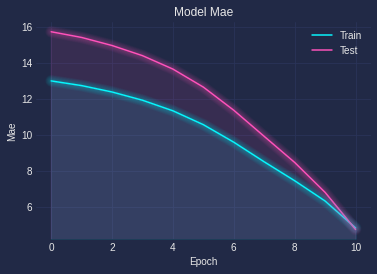

In [ ]:
plt.plot(history.history['mae']) 
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right') 
mplcyberpunk.add_glow_effects()
plt.show()

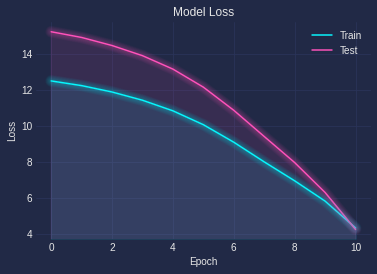

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
mplcyberpunk.add_glow_effects()
plt.show()